## Flux scanning based on enforced objective flux (FSEOF)

### Intro to gene prediction targets

In the realm of metabolic engineering for improving strains to produce specific bioproducts, pinpointing genes for deletion or amplification is crucial. While various methods have existed to identify genes suitable for deletion using genome-scale metabolic models and flux analysis, finding gene targets for amplification has been a challenging task. However, a new strategy, termed flux scanning based on enforced objective flux (FSEOF), has been introduced. FSEOF methodically examines all metabolic fluxes within the model and identifies those that rise when the flux directing the production of the desired product is enforced as an additional constraint during flux analysis (Choi, Lee, Kim, & Woo, 2010).

### Import the required libraries and the model.

In [1]:
### Import the required libraries and the model.
from cameo.strain_design.deterministic.flux_variability_based import FSEOF
from pytest import approx
from cobra.io import read_sbml_model
from cobra import Model, Reaction, Metabolite
import pandas as pd

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline


model = read_sbml_model('2018_ATCC1015_GSM_iJB1325.xml') #The model is refered from (Brandl, J., Aguilar-Pontes, M. V., Schape, P., Norregaard, A., Arvas, M., Ram, A. F. J., Meyer, V., Tsang, A., de Vries, R. P., & Andersen, M. R. (2018). A community-driven reconstruction of the Aspergillus niger metabolic network. Fungal Biology and Biotechnology, 5, 16. )

OSError: The file with '2018_ATCC1015_GSM_iJB1325.xml' does not exist, or is not an SBML string. Provide the path to an existing SBML file or a valid SBML string representation:


### Media setup

In [ ]:
#Add extracellular metanolites
PNTOe = Metabolite('PNTOe', formula='C9H17NO5', name='(R)-Pantothenate', compartment='e') 
model.add_metabolites([PNTOe])

DHFe = Metabolite('DHFe', formula='C19H21N7O6', name='7,8-Dihydrofolate', compartment='e') 
model.add_metabolites([DHFe])

PABAe = Metabolite('PABAe', formula='C7H7NO2', name='4-Aminobenzoate', compartment='e') 
model.add_metabolites([PABAe])

PLe = Metabolite('PLe', formula='C8H9NO3', name='Pyridoxal', compartment='e') 
model.add_metabolites([PLe])

RIBOFLAVe = Metabolite('RIBOFLAVe', formula='C17H20N4O6', name='Riboflavin', compartment='e') 
model.add_metabolites([RIBOFLAVe])

#Add transport reactions
r2392 = Reaction('r2392')
r2392.name = '(R)-Pantothenate transport'
r2392.subsystem = "Transport"
r2392.lower_bound = -1000
r2392.add_metabolites({PNTOe: -1.0, model.metabolites.PNTO: 1.0})

r2393 = Reaction('r2393')
r2393.name = '7,8-Dihydrofolate transport'
r2393.lower_bound = -1000
r2393.subsystem = 'Transport'
r2393.add_metabolites({DHFe: -1.0, model.metabolites.DHF: 1.0})

r2394 = Reaction('r2394')
r2394.name = '4-Aminobenzoate transport'
r2394.lower_bound = -1000
r2394.subsystem = 'Transport'
r2394.add_metabolites({PABAe: -1.0, model.metabolites.PABA: 1.0})

r2395 = Reaction('r2395')
r2395.name = 'Pyridoxal transport'
r2395.lower_bound = -1000
r2395.subsystem = 'Transport'
r2395.add_metabolites({PLe: -1.0, model.metabolites.PL: 1.0})

r2396 = Reaction('r2396')
r2396.name = 'Riboflavin transport'
r2396.lower_bound = -1000
r2396.subsystem = 'Transport'
r2396.add_metabolites({RIBOFLAVe: -1.0, model.metabolites.RIBOFLAV: 1.0})

r2397 = Reaction('r2397')
r2397.name = 'Copper transport'
r2397.lower_bound = -1000
r2397.subsystem = 'Transport'
r2397.add_metabolites({model.metabolites.CUe: -1.0, model.metabolites.CU: 1.0})

#Add boundary conditions
model.add_boundary(model.metabolites.PNTOe, type="exchange", reaction_id= "BOUNDARY_PNTOe")
model.add_boundary(model.metabolites.DHFe, type="exchange", reaction_id= "BOUNDARY_DHFe")
model.add_boundary(model.metabolites.PABAe, type="exchange", reaction_id= "BOUNDARY_PABAe")
model.add_boundary(model.metabolites.PLe, type="exchange", reaction_id= "BOUNDARY_PLe")
model.add_boundary(model.metabolites.RIBOFLAVe, type="exchange", reaction_id= "BOUNDARY_RIBOFLAVe")
model.add_boundary(model.metabolites.CUe, type="exchange", reaction_id= "BOUNDARY_CUe")

medium_blank = {key: 0 for key in model.medium}
YESmedium = medium_blank # Setup the object for YESmedium

#Set the concentration for the amino acids
YESmedium['BOUNDARY_GLCe'] = 20 
# YESmedium['BOUNDARY_ALAe'] = 10
YESmedium['BOUNDARY_ARGe'] = 10
# YESmedium['BOUNDARY_ASPe'] = 10
# YESmedium['BOUNDARY_CYSe'] = 10
# YESmedium['BOUNDARY_GLUe'] = 10
# YESmedium['BOUNDARY_GLYe'] = 10
# YESmedium['BOUNDARY_HISe'] = 10
# YESmedium['BOUNDARY_ILEe'] = 10
# YESmedium['BOUNDARY_LEUe'] = 10
# YESmedium['BOUNDARY_LYSe'] = 10
# YESmedium['BOUNDARY_METe'] = 10
# YESmedium['BOUNDARY_PHEe'] = 10
# YESmedium['BOUNDARY_PROe'] = 10
# YESmedium['BOUNDARY_SERe'] = 10
# YESmedium['BOUNDARY_THRe'] = 10
# YESmedium['BOUNDARY_TRPe'] = 10
# YESmedium['BOUNDARY_TYRe'] = 10
# YESmedium['BOUNDARY_VALe'] = 10

#Set the concentration for the supplements
YESmedium['BOUNDARY_NH4e'] = 5 #Ammonium  
YESmedium['BOUNDARY_SLFe'] = 5.5 #Sulfate
YESmedium['BOUNDARY_BTe'] = 2/10**6 #Biotin 
YESmedium['BOUNDARY_PNTOe'] = 400/10**6 #Pantothenic Acid
YESmedium['BOUNDARY_DHFe'] = 2/10**6 #Folic acid
YESmedium['BOUNDARY_MYOIe'] = 4000/10**6 #myo-Inositol
YESmedium['BOUNDARY_NICAe'] = 800/10**6 #Nicotinate
YESmedium['BOUNDARY_PABAe'] = 400/10**6 #4-Aminobenzoate
YESmedium['BOUNDARY_PLe'] = 800/10**6 #Pyridoxal
YESmedium['BOUNDARY_RIBOFLAVe'] = 200/10**6 #Riboflavin
YESmedium['BOUNDARY_THIAe'] = 800/10**6 #Thiamine
YESmedium['BOUNDARY_CUe'] = 80/10**6 #Copper
YESmedium['BOUNDARY_Ke'] = 2 #Potassium
YESmedium['BOUNDARY_FE2e'] = 200/10**6 #Ferric 
YESmedium['BOUNDARY_MNe'] = 400/10**6 #Manganese
YESmedium['BOUNDARY_MOe'] = 200/10**6 #Molybdate
YESmedium['BOUNDARY_ZNe'] = 400/10**6 #Zinc
YESmedium['BOUNDARY_PIe'] = 1 #Phosphate
YESmedium['BOUNDARY_CAe'] = 0.4 #Calcium 

#Set the condition
YESmedium['BOUNDARY_H2Oe'] = 1000 #Water
YESmedium['BOUNDARY_O2e'] = 1000 #Oxygen 

# Setting YES as control medium
model.medium = YESmedium

model.reactions.BOUNDARY_GLCe.bonds = -20,1000
model.reactions.BOUNDARY_ARGe.bonds = -10,1000

### FSEOF Analysis 

In [ ]:
fseof = FSEOF(model)
result = fseof.run(target = model.reactions.r1976)
df = result.data_frame

After running the analysis we can plot the predicted targets that shows an increase or decrease in flux when the target is set to the last step of the yanuthone D pathway. 

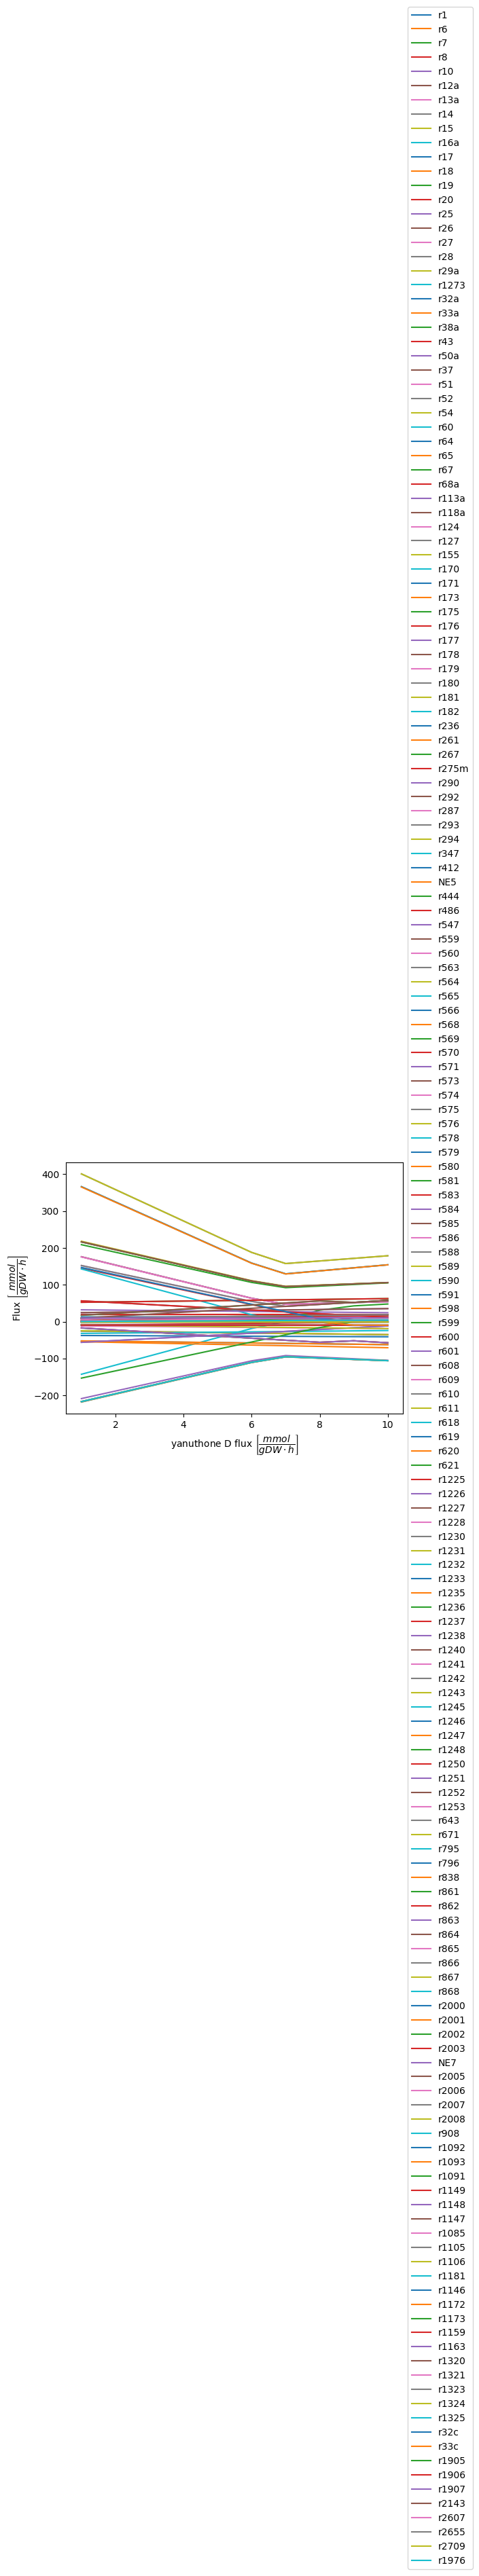

In [ ]:
result.data_frame.T.plot()
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r"yanuthone D flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.ylabel(r"Flux $\left[\dfrac{mmol}{gDW\cdot h}\right]$");
plt.show()

To get a better overview of the results we can sort the values and remove all the ones that have a flux change of 0.0

In [ ]:
# sorting the dataframe
df= df.sort_values([1], ascending = False)
 
from pytest import approx
# removing genes from dataframe 
removed_zero = (df != approx(0.0)).all(axis=1)
df = df.loc[removed_zero]
df.head()

,1,2,3,4,5,6,7,8,9,10
r14,400.839450,358.236466,315.633482,273.030498,230.427514,187.824531,157.490239,164.547812,171.605384,178.662315
r15,400.839450,358.236466,315.633482,273.030498,230.427514,187.824531,157.490239,164.547812,171.605384,178.662315
r16a,366.175053,324.702078,283.229103,241.756128,200.283153,158.810178,129.605896,137.793478,145.981059,154.168208
r17,366.175053,324.702078,283.229103,241.756128,200.283153,158.810178,129.605896,137.793478,145.981059,154.168208
r18,365.250645,323.869132,282.487618,241.106105,199.724591,158.343078,129.230257,137.509300,145.788343,154.066958


These results show 10 the enzymes that show the highest increase or decrease in flux. The whole dataframe consistes of 95 rows which means 95 reactions have a change of flux. 

To get a better overview of the changes in flux and genes we can plot the in the following way. 

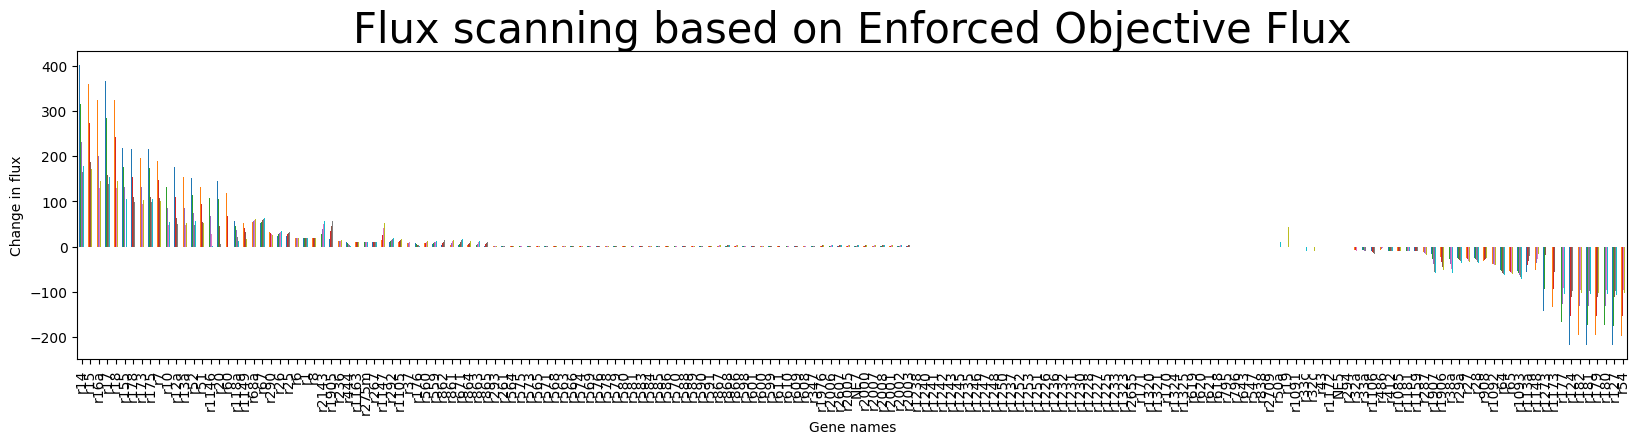

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def assign_color(val):
    if val >= 0:
        return 'purple'
    else:
        return 'green'

# Assuming df is your pandas DataFrame

# Assuming you have df and it contains the necessary data

fig, ax = plt.subplots(figsize=(20, 4))
df.plot(ax=ax, legend=None, kind='bar', grid=False)

# Applying specific colors to the bars based on the condition
# colors = bar_color(df, "green", "red")
# for i, color in enumerate(colors):
#     for bar in ax.patches[i * len(df.columns): (i + 1) * len(df.columns)]:
#         bar.set_color(color)

ax.set_ylabel('Change in flux')
ax.set_xlabel('Gene names')
ax.set_title('Flux scanning based on Enforced Objective Flux', size=30)
plt.show()


#### We want to see what the relative change is for the different fluxes. This can be calculated like this: R = (B-A) / B +1


In [ ]:
df['relative_change_in_flux'] = (df[10]-df[1])/df[10] +1

#### If we look at the reactions that have a higher relative_change_in_flux than 80% we can find target rections. 

In [ ]:
target_reactions_df = df[df['relative_change_in_flux'] > 1.8]

In [ ]:
target_reactions_df

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
r1147,9.439125,14.775400,20.111674,25.447948,30.784222,36.120497,41.456771,46.793045,52.129320,57.465509,1.835743
r862,2.374883,3.954702,5.534522,7.114341,8.694161,10.273980,11.853799,13.433619,15.013438,16.593253,1.856877
r861,2.374883,3.954702,5.534522,7.114341,8.694161,10.273980,11.853799,13.433619,15.013438,16.593253,1.856877
r671,2.374883,3.954702,5.534522,7.114341,8.694161,10.273980,11.853799,13.433619,15.013438,16.593253,1.856877
r864,1.962040,3.129016,4.295992,5.462968,6.629944,7.796921,8.963897,10.130873,11.297849,12.464821,1.842594
r863,1.962040,3.129016,4.295992,5.462968,6.629944,7.796921,8.963897,10.130873,11.297849,12.464821,1.842594
r865,1.962040,3.129016,4.295992,5.462968,6.629944,7.796921,8.963897,10.130873,11.297849,12.464821,1.842594
r867,0.654013,1.043005,1.431997,1.820989,2.209981,2.598974,2.987966,3.376958,3.765950,4.154940,1.842594
r868,0.654013,1.043005,1.431997,1.820989,2.209981,2.598974,2.987966,3.376958,3.765950,4.154940,1.842594
r866,0.654013,1.043005,1.431997,1.820989,2.209981,2.598974,2.987966,3.376958,3.765950,4.154940,1.842594


In [ ]:
df = target_reactions_df.drop(labels='relative_change_in_flux', axis=1)

Text(0.5, 1.0, 'Reactions with a relative change in Flux > 80%')

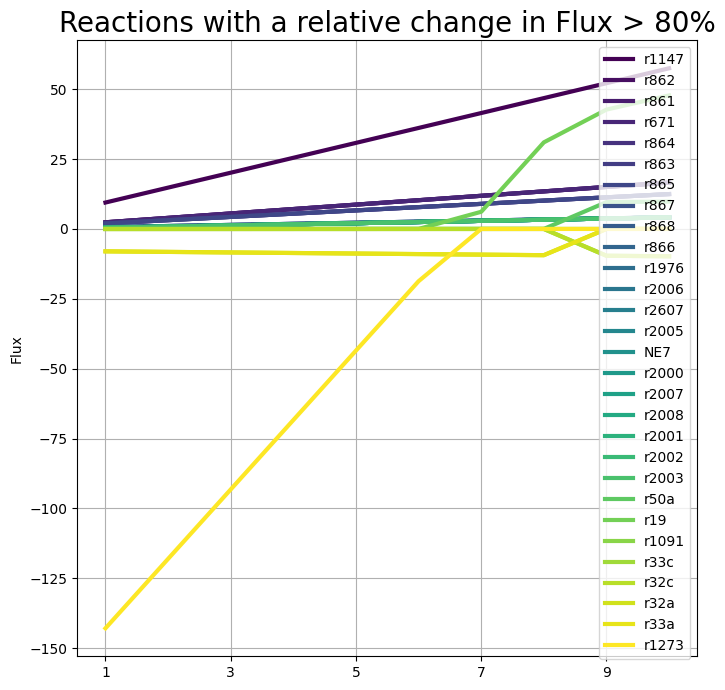

In [ ]:
fig = df.T.plot(cmap="viridis",figsize=(8, 8), grid =True, linewidth=3);
fig.set_ylabel('Flux')
fig.set_title('Reactions with a relative change in Flux > 80%', size=20)

What we see here is that many of the reactions have the same relative change in flux. This is probably due to them being linked to eachother in the model.

In [ ]:
#lowest flux reactions
target_reactions_df.tail(10)

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
r2002,0.412843,0.825686,1.238530,1.651373,2.064216,2.477059,2.889903,3.302746,3.715589,4.128432,1.900000
r2003,0.412843,0.825686,1.238530,1.651373,2.064216,2.477059,2.889903,3.302746,3.715589,4.128432,1.900000
r50a,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.586299,9.782244,2.000000
r19,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.134346,30.964625,42.686685,47.758675,2.000000
r1091,-0.004942,-0.004374,-0.003806,-0.003238,-0.002671,-0.002103,-0.001535,-0.000967,-0.000399,0.000000,inf
r33c,-0.035547,-0.032031,-0.028516,-0.025000,-0.021485,-0.017969,-0.014454,-0.010938,-9.593722,-9.786151,1.996368
r32c,-0.035547,-0.032031,-0.028516,-0.025000,-0.021485,-0.017969,-0.014454,-0.010938,-9.593722,-9.786151,1.996368
r32a,-8.018846,-8.214778,-8.410709,-8.606641,-8.802573,-8.998504,-9.194436,-9.390368,0.000000,0.000000,inf
r33a,-8.018846,-8.214778,-8.410709,-8.606641,-8.802573,-8.998504,-9.194436,-9.390368,0.000000,0.000000,inf
r1273,-142.847323,-118.017045,-93.186766,-68.356488,-43.526210,-18.695932,0.000000,0.000000,0.000000,0.000000,inf


In [ ]:
#higest flux reactions
target_reactions_df.head(10)

,1,2,3,4,5,6,7,8,9,10,relative_change_in_flux
r1147,9.439125,14.775400,20.111674,25.447948,30.784222,36.120497,41.456771,46.793045,52.129320,57.465509,1.835743
r862,2.374883,3.954702,5.534522,7.114341,8.694161,10.273980,11.853799,13.433619,15.013438,16.593253,1.856877
r861,2.374883,3.954702,5.534522,7.114341,8.694161,10.273980,11.853799,13.433619,15.013438,16.593253,1.856877
r671,2.374883,3.954702,5.534522,7.114341,8.694161,10.273980,11.853799,13.433619,15.013438,16.593253,1.856877
r864,1.962040,3.129016,4.295992,5.462968,6.629944,7.796921,8.963897,10.130873,11.297849,12.464821,1.842594
r863,1.962040,3.129016,4.295992,5.462968,6.629944,7.796921,8.963897,10.130873,11.297849,12.464821,1.842594
r865,1.962040,3.129016,4.295992,5.462968,6.629944,7.796921,8.963897,10.130873,11.297849,12.464821,1.842594
r867,0.654013,1.043005,1.431997,1.820989,2.209981,2.598974,2.987966,3.376958,3.765950,4.154940,1.842594
r868,0.654013,1.043005,1.431997,1.820989,2.209981,2.598974,2.987966,3.376958,3.765950,4.154940,1.842594
r866,0.654013,1.043005,1.431997,1.820989,2.209981,2.598974,2.987966,3.376958,3.765950,4.154940,1.842594


### Targets for upregulation: 

| Reaction ID | Description                                   | Catalytic reaction                                   |
|-------------|-----------------------------------------------|-----------------------------------------------|
| r1147       | Acetate diffusion                         | Diffusion of acetate from cytoplasm to mitochondrial                          |
| r862       | 3-hydroxy-3-methylglutaryl coenzyme A synthase                         | Convert (S)-3-Hydroxy-3-methylglutaryl-CoA to Mevalonate and Coenzyme A with presence of 2 NADPH                           |
| r861       | 3-hydroxy-3-methylglutaryl coenzyme A synthase                            | Convert Acetoacetyl coenzyme A and Acetyl coenzyme A to Coenzyme A and (S)-3-Hydroxy-3-methylglutaryl-CoA with presence of water                  |
| r671        | Acetyl-CoA C-acetyltransferase          | Convert 2 Acetyl coenzyme A to Acetoacetyl coenzyme A and Coenzyme A                        |
| r864       |Phosphomevalonate kinase                   | Convert mevalonate 5-phosphate and ATP to mevalonate 5-diphosphate and ADP                |




### Targets for downregulation: 

| Reaction ID | Description                                   | Catalytic reaction                                   |
|-------------|-----------------------------------------------|-----------------------------------------------|
| r32c      | Aconitate hydratase                        | Convert Citrate to cis-Aconitate and water in cytoplasm                    |
| r33c       | Aconitate hydratase                       | Convert cis-Aconitate to Isocitrate and water in cytoplasm                         |

